# Time series with Azure Open AI

In [ ]:
# pip install matplotlib

In [ ]:
# pip install seaborn

In [1]:
import datetime
import json
import matplotlib.pyplot as plt
import openai
import os
import pandas as pd
import seaborn as sns
import sys

from dotenv import load_dotenv

In [2]:
# load_dotenv("azure.env")

# Azure Open AI
openai.api_type: str = "azure"
openai.api_key = "cf0908d632284d8db6351dbba845812b"
openai.api_base = "https://opeinaiexample.openai.azure.com/"
openai.api_version ="2023-05-15"

print("Open AI version:", openai.__version__)

Open AI version: 0.28.1


In [3]:
sys.version

'3.12.3 (tags/v3.12.3:f6650f9, Apr  9 2024, 14:05:25) [MSC v.1938 64 bit (AMD64)]'

In [4]:
print(f"Today is {datetime.datetime.today().strftime('%d-%b-%Y %H:%M:%S')}")

Today is 15-May-2024 10:05:28


## Time series dataset

In [5]:
ts_file = "timeserie.csv"

In [ ]:
!ls $ts_file -lh

In [6]:
df = pd.read_csv(ts_file)

df["date"] = pd.to_datetime(df["date"], format="%d-%m-%Y")
df = df.set_index("date")
df

,y
date,
2010-01-01,112.0
2010-02-01,118.0
2010-03-01,132.0
2010-04-01,129.0
2010-05-01,121.0
...,...
2021-08-01,606.0
2021-09-01,508.0
2021-10-01,461.0


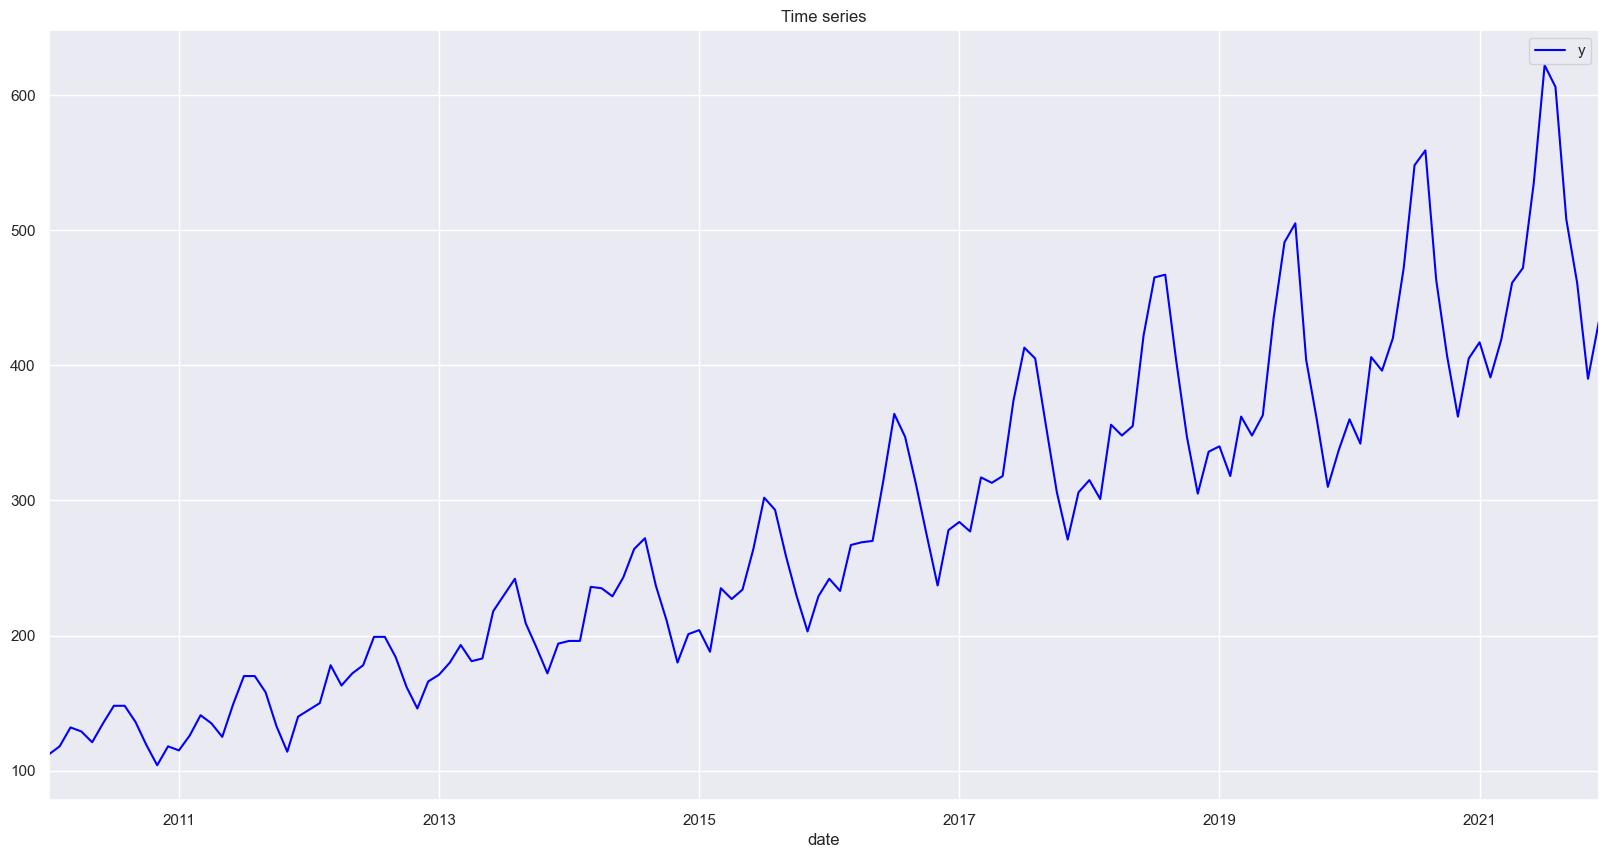

In [7]:
plt.rcParams["figure.figsize"] = [20, 10]
sns.set_theme(palette="Set2")
df.plot(title="y", color="blue")
plt.title("Time series")
plt.show()

In [8]:
nb = 24

df_test = df.iloc[-nb:]
df_train = df.iloc[:-nb]
len(df_test), len(df_train)

(24, 120)

## Azure Open AI for forecasting

In [9]:
model = "chat35"

In [10]:
def chat_gpt_forecast(
    data, horizon, frequency, time_idx="date", forecast_col="forecast", model=model
):
    prompt = f""" 
    Given the dataset delimited by the triple backticks, 
    forecast next {horizon} values of the time series. 
    The time series is a {frequency} time series.

    Return the answer in JSON format, containing two keys: '{time_idx}' 
    and '{forecast_col}', and list of values assigned to them. 
    Return only the forecasts, not the Python code.

    ``` {data.to_string()}``` 
    """

    messages = [{"role": "user", "content": prompt}]

    response = openai.ChatCompletion.create(
        engine=model,
        messages=messages,
        temperature=0,
    )

    df = pd.DataFrame(json.loads(response.choices[0].message["content"]))

    return df

In [11]:
df_forecasts = chat_gpt_forecast(df_train, 24, "monthly")

In [12]:
df_forecasts

,date,forecast
0,2020-01-01,366.0
1,2020-02-01,358.0
2,2020-03-01,405.0
3,2020-04-01,392.0
4,2020-05-01,402.0
5,2020-06-01,470.0
6,2020-07-01,525.0
7,2020-08-01,536.0
8,2020-09-01,431.0
9,2020-10-01,381.0


In [13]:
df_test.reset_index(drop=False, inplace=True)

all_df = pd.concat([df_forecasts, df_test["y"]], axis=1)
all_df["diff"] = all_df["forecast"] - all_df["y"]
all_df["pct_diff"] = ((all_df["forecast"] - all_df["y"]) / all_df["y"]) * 100
all_df

,date,forecast,y,diff,pct_diff
0,2020-01-01,366.0,360.0,6.0,1.666667
1,2020-02-01,358.0,342.0,16.0,4.678363
2,2020-03-01,405.0,406.0,-1.0,-0.246305
3,2020-04-01,392.0,396.0,-4.0,-1.010101
4,2020-05-01,402.0,420.0,-18.0,-4.285714
5,2020-06-01,470.0,472.0,-2.0,-0.423729
6,2020-07-01,525.0,548.0,-23.0,-4.197080
7,2020-08-01,536.0,559.0,-23.0,-4.114490
8,2020-09-01,431.0,463.0,-32.0,-6.911447
9,2020-10-01,381.0,407.0,-26.0,-6.388206


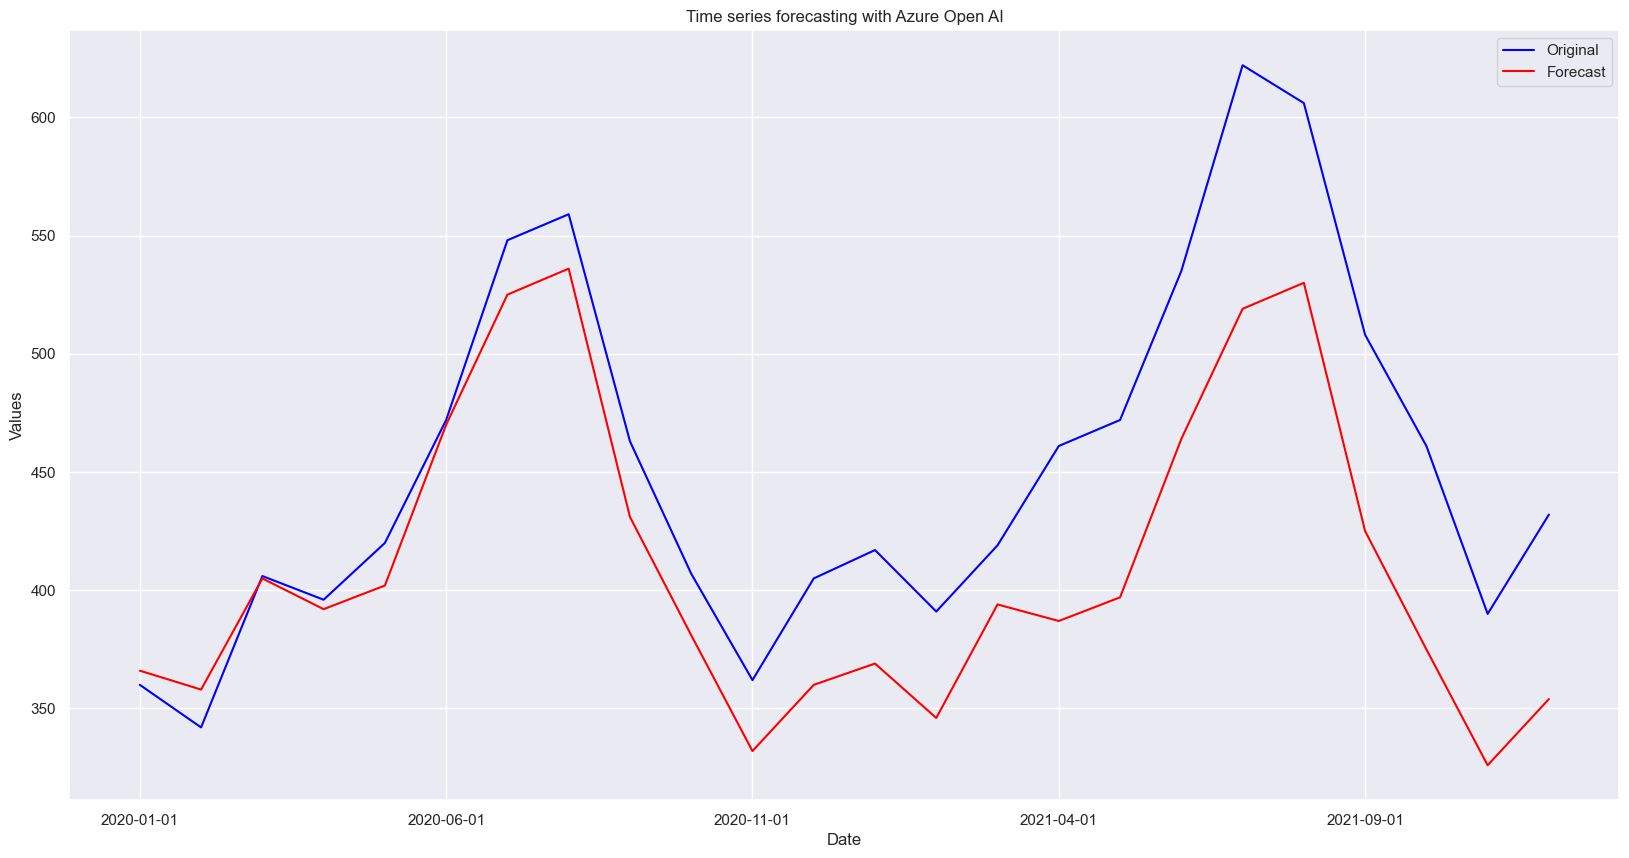

In [14]:
all_df.plot(x="date", y=["y", "forecast"], color=["blue", "red"])

plt.title("Time series forecasting with Azure Open AI")
plt.xlabel("Date")
plt.ylabel("Values")
plt.legend(["Original", "Forecast"])
plt.grid(True)

plt.show()

In [15]:
df_forecasts["date"] = pd.to_datetime(df_forecasts["date"], format="%Y-%m-%d")
df_allresults = pd.merge(df, df_forecasts, on="date", how="left")

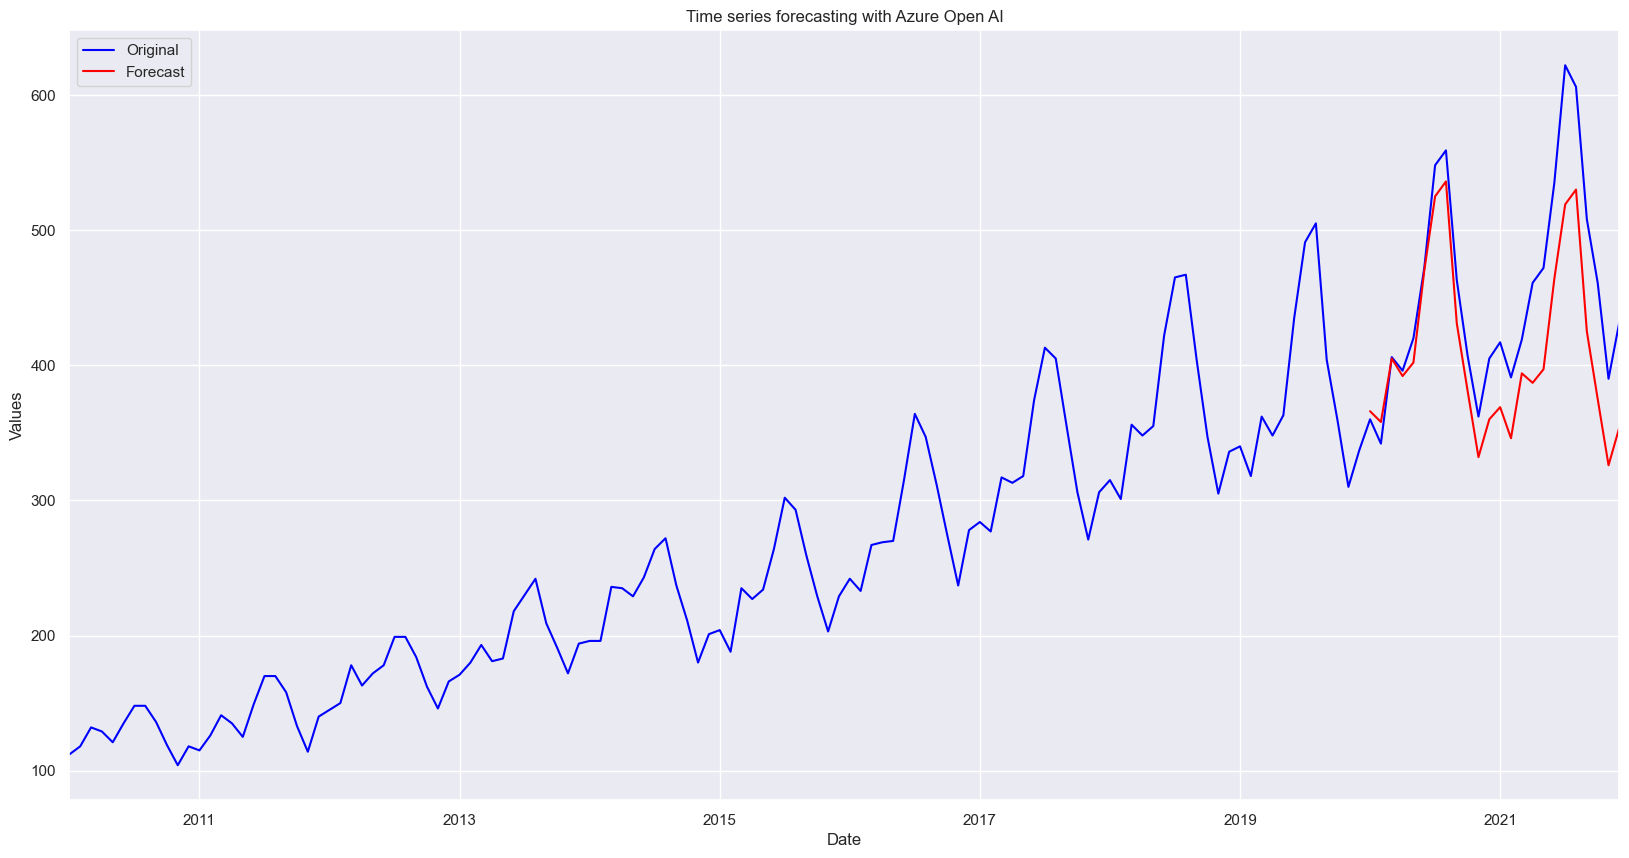

In [16]:
df_allresults.plot(x="date", y=["y", "forecast"], color=["blue", "red"])

plt.title("Time series forecasting with Azure Open AI")
plt.xlabel("Date")
plt.ylabel("Values")
plt.legend(["Original", "Forecast"])
plt.grid(True)
plt.legend(["Original", "Forecast"])
plt.show()

## Q&A on a time serie with Azure Open AI

In [17]:
def ask_timeserie(prompt):
    """
    Ask Time series
    """
    query = f"{prompt} of {df}."

    response = openai.Completion.create(
        engine="timeseries",
        prompt=query,
        temperature=0,
        max_tokens=1000,
        n=1,
        stop=None,
    )

    return response["choices"][0]["text"].replace("\n\n", "")

In [18]:
prompt = "What are the min and max values?"

print(ask_timeserie(prompt))

The minimum value is 112.0 and the maximum value is 606.0.


In [19]:
prompt = "What are the min and max dates?"

print(ask_timeserie(prompt))

The min date is 2010-01-01 and the max date is 2021-12-01.


In [20]:
prompt = "What are the mean and median values?"

print(ask_timeserie(prompt))

The mean value is 312.5 and the median value is 291.5.


In [21]:
prompt = "What is the variance of this time serie?"

print(ask_timeserie(prompt))

The variance of this time series is 10,528.


In [22]:
prompt = "Forecast the next data point in this time series"

print(ask_timeserie(prompt))

It is not possible to accurately forecast the next data point without more information about the time series, such as the underlying trend, seasonality, and any other relevant factors. Additionally, the data provided only covers a period of 11 years, which may not be enough to accurately predict future values. A more comprehensive analysis and modeling approach would be needed to make a reliable forecast.


In [23]:
prompt = "What is the trend of this time serie?"

print(ask_timeserie(prompt))

The trend of this time series appears to be increasing, with some fluctuations and seasonal patterns.


In [24]:
prompt = "What is the periodicity of this time serie?"

print(ask_timeserie(prompt))

The periodicity of this time series is monthly.


In [25]:
prompt = "Take the last 2 values and generate the mean of it"

print(ask_timeserie(prompt))

tail(2).mean()y    411.0
dtype: float64


In [26]:
prompt = "Take the last 3 values and generate the mean of it"

print(ask_timeserie(prompt))

tail(3).mean()y    427.666667
dtype: float64


In [27]:
prompt = "How is the average variation in %?"

print(ask_timeserie(prompt))

To calculate the average variation in %, we first need to calculate the percentage change for each month. This can be done by taking the difference between the current month's value and the previous month's value, and then dividing by the previous month's value. For example, for February 2010, the percentage change would be (118-112)/112 = 0.0536 or 5.36%.Once we have calculated the percentage change for each month, we can then find the average by adding all the percentage changes and dividing by the total number of months. In this case, there are 144 months, so the average variation in % would be:(5.36% + 11.86% + 9.09% + 6.98% + 4.96% + ... + 3.96%)/144 = 6.25%Therefore, the average variation in % for this dataset is 6.25%. This means that on average, the value of y has increased or decreased by 6.25% each month. 


In [28]:
prompt = "How do you define this time serie in terms of trend, seasonnality and cyclical part?"

print(ask_timeserie(prompt))

This time series appears to have an overall increasing trend, with a seasonal pattern that repeats every year. There may also be some cyclical fluctuations within each year, but it is difficult to determine without more data.
